# 02.B: Nearest neighbors classifiers

In [78]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mylib as my

## Nearest Neighbor (NN)
Given and dataset $\boldsymbol{D} = [\boldsymbol{X}\ \ \boldsymbol{y}]$ and an unseen example $\boldsymbol{x}$, this classifier:
* calculates the distances between $\boldsymbol{x}$ and every example in $\boldsymbol{D}$. Using the Euclidean distance, we have:
    $$
      distance(\boldsymbol{x^{(a)}}, \boldsymbol{x^{(b)}}) = \Vert\boldsymbol{x^{(a)}} - \boldsymbol{x^{(b)}}\Vert_2 = \sqrt{\sum_{i = 1}^{m} (x_i^{(a)} - x_i^{(b)})^2}
    $$
* finds the example that is nearest to X and return its $y$ 

Here is a class implementing this classifier

In [79]:
class NearestNeighborClassifier:
    def __init__(self, dataset):
        self.ds = dataset
        
    def calc_distance(self, x, y):
        distance = 0.0
        for i in np.arange(len(x)):
            distance += (x[i] - y[i])**2
                
        return math.sqrt(distance)
    
    def predict(self, unseen):
        if unseen.ndim == 1:
            distances = np.full(self.ds.N, 0.0)
            for i, ex in enumerate(self.ds.inputs):
                distances[i] = self.calc_distance(unseen, ex)

            return self.ds.target[distances.argmin()]
        else:
            return np.array([self.predict(ex) for ex in unseen])

## An example
Let's quickly test this. Here a sample dataset with three classes:

In [80]:
basis = np.array([[3, 14],[4, 4],[10, 9]])
a_ = np.concatenate((
        basis[0,0] + np.random.normal(loc=1, scale=2.5, size=(50, 1)), 
        basis[0, 1] + np.random.normal(loc=1, scale=2.6, size=(50, 1)), 
        np.full(50, 0).reshape(50,1)), axis= 1)

b_ = np.concatenate((
        basis[1,0] + np.random.normal(loc=.8, scale=2.5, size=(50, 1)), 
        basis[1, 1] + np.random.normal(loc=.8, scale=2.4, size=(50, 1)), 
        np.full(50, 1).reshape(50,1)), axis= 1)

c_ = np.concatenate((
        basis[2,0] + np.random.normal(loc=.5, scale=2.5, size=(50, 1)), 
        basis[2, 1] + np.random.normal(loc=.5, scale=2.6, size=(50, 1)), 
        np.full(50, 2).reshape(50,1)), axis= 1)

In [81]:
# trying out the concatenate function to better understand it
np.concatenate((np.array([[1,2],[3,4]]), np.array([[5,6],[7,8]])), axis=1)

array([[1, 2, 5, 6],
       [3, 4, 7, 8]])

which looks like this:

Text(0.5, 1.0, 'Samle three classes data')

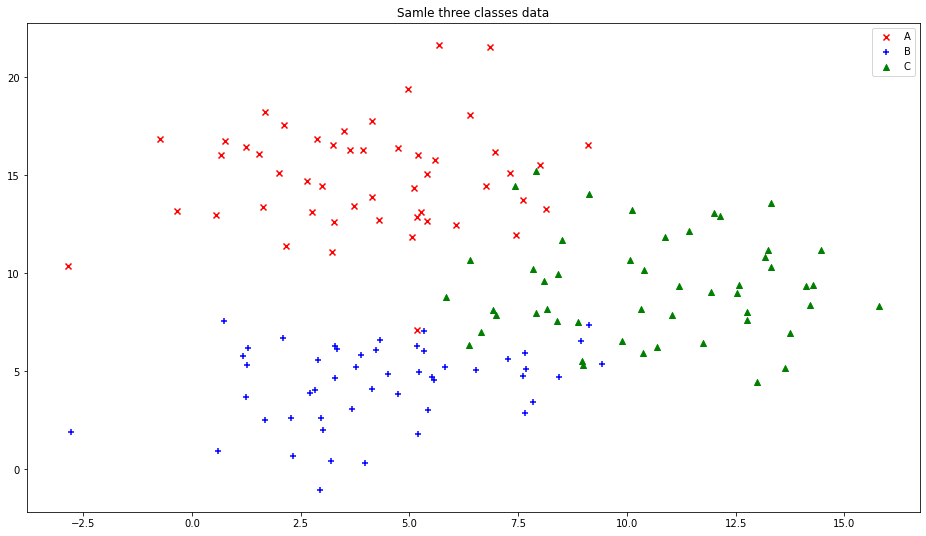

In [82]:
plt.figure(figsize=(16,9))
plt.scatter(a_[:, 0], a_[:, 1], color='red', marker='x', label='A')
plt.scatter(b_[:, 0], b_[:, 1], color='blue', marker='+', label='B')
plt.scatter(c_[:, 0], c_[:, 1], color='green', marker='^', label='C')

plt.legend(loc='best')
plt.title('Samle three classes data')

Let's put this data into a dataset and split it into a training and test sets.

In [83]:
data = pd.DataFrame(np.concatenate([a_, b_, c_], axis=0), columns=['x1', 'x2', 't'])
ds = my.DataSet(data, y=True) # y=True means the right-most column is the target of data
train, test = ds.train_test_split(test_portion=.33, shuffle=True)

Let's train this classifier and print its output on the training set side by side with the actual training labels.

In [84]:
nn = NearestNeighborClassifier(train)

results = pd.DataFrame(columns=["Actual", "Predicted"])

results["Actual"] = train.target.flatten()
results["Predicted"] = nn.predict(train.inputs)
results.head()

,Actual,Predicted
0,2.0,2.0
1,1.0,1.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


Here is the corresponding confusion matrix and accuracy.

In [85]:
cm = my.confusion_matrix(train.target, nn.predict(train.inputs))
accuracy = np.trace(cm) / np.sum(cm) # trace gives diagonal sum and sum is sum of all nums in matrix
print(cm)
print('Train accuracy: ', accuracy)

[[32  0  0]
 [ 0 34  0]
 [ 0  0 35]]
Train accuracy:  1.0


This is a perfect accuracy which corresponds to a training error of $\boldsymbol{E}_{train} = 0$. This is not necessarily a good thing. **Why?** Maybe this is because the algorithm is too rigid and biased and has created a model that only works on the data it trained with.

Let's see how this trained model performs on the unseen test set. 

In [86]:
results = pd.DataFrame(columns=["Actual", "Predicted"])

results["Actual"] = test.target.flatten()
results["Predicted"] = nn.predict(test.inputs)
results.head(10)

,Actual,Predicted
0,0.0,0.0
1,2.0,2.0
2,0.0,0.0
3,0.0,0.0
4,1.0,1.0
5,0.0,0.0
6,0.0,0.0
7,2.0,2.0
8,0.0,0.0
9,0.0,0.0


Here is the corresponding confusion matrix and accuracy.

In [87]:
cm = my.confusion_matrix(test.target, nn.predict(test.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Test accuracy: ', accuracy)

[[18  0  0]
 [ 0 16  0]
 [ 1  1 13]]
Test accuracy:  0.9591836734693877


Here are the decision regions of this trained model with both the training examples and the test examples side by side. **Uncomment the `%%timeit` command to see how long it takes to produce these plots and get a feeling of how computationally expensive the NN classifier can be.** Keep in mind that `%%timeit` will run your code multiple times to get a more accurate measure of how long it took. So it may take a while to finish.

KeyboardInterrupt: 

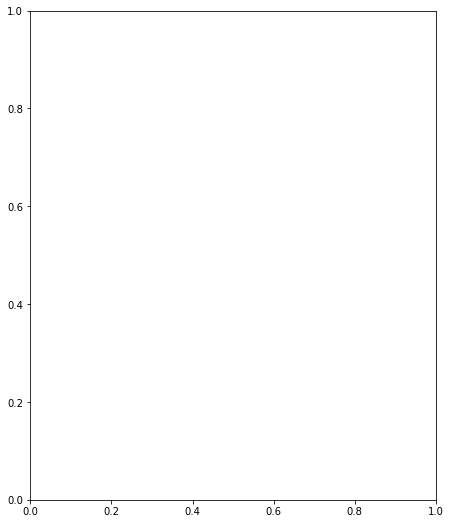

In [77]:
##%%timeit
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,2,1)
my.plot_decision_regions(train.inputs, train.target, nn, title="Training decision regions", ax=ax)
ax = fig.add_subplot(1,2,2)
my.plot_decision_regions(test.inputs, test.target, nn, title="Test decision regions", ax=ax)

## A more efficient implementation
The way class `NearestNeighborClassifier` calculated the distances can be improved by taking advantage of NumPy vectorization. Here is a shorter and improved version. **Do you see the difference?**

In [88]:
class NearestNeighborClassifier:
    def __init__(self, dataset):
        self.ds = dataset
    
    def predict(self, unseen):
        if unseen.ndim == 1:
            distances = np.sqrt(np.sum((self.ds.inputs-unseen)**2, axis=1))

            return self.ds.target[distances.argmin()]
        else:
            return np.array([self.predict(ex) for ex in unseen])

Using the above example, to test this new class gives the following for the training set 

In [89]:
nn = NearestNeighborClassifier(train)

results = pd.DataFrame(columns=["Actual", "Predicted"])

results["Actual"] = train.target.flatten()
results["Predicted"] = nn.predict(train.inputs)
print(results.head(10))

cm = my.confusion_matrix(train.target, nn.predict(train.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Train accuracy: ', accuracy)

   Actual  Predicted
0     2.0        2.0
1     1.0        1.0
2     0.0        0.0
3     0.0        0.0
4     0.0        0.0
5     0.0        0.0
6     1.0        1.0
7     1.0        1.0
8     2.0        2.0
9     0.0        0.0
[[32  0  0]
 [ 0 34  0]
 [ 0  0 35]]
Train accuracy:  1.0


and the following for the test set:

In [90]:
results = pd.DataFrame(columns=["Actual", "Predicted"])

results["Actual"] = test.target.flatten()
results["Predicted"] = nn.predict(test.inputs)
print(results.head(10))

cm = my.confusion_matrix(test.target, nn.predict(test.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Test accuracy: ', accuracy)

   Actual  Predicted
0     0.0        0.0
1     2.0        2.0
2     0.0        0.0
3     0.0        0.0
4     1.0        1.0
5     0.0        0.0
6     0.0        0.0
7     2.0        2.0
8     0.0        0.0
9     0.0        0.0
[[18  0  0]
 [ 0 16  0]
 [ 1  1 13]]
Test accuracy:  0.9591836734693877


This is no longer a perfect accuracy meaning that test error of $\boldsymbol{E}_{test} > 0$.

Here are again the decision regions of this trained model with both the training examples and the test examples side by side. **Uncomment the `%%timeit` command to see how long it takes to produce these plots using the improved NN classifier and compare that to the performance of the first implementation.**

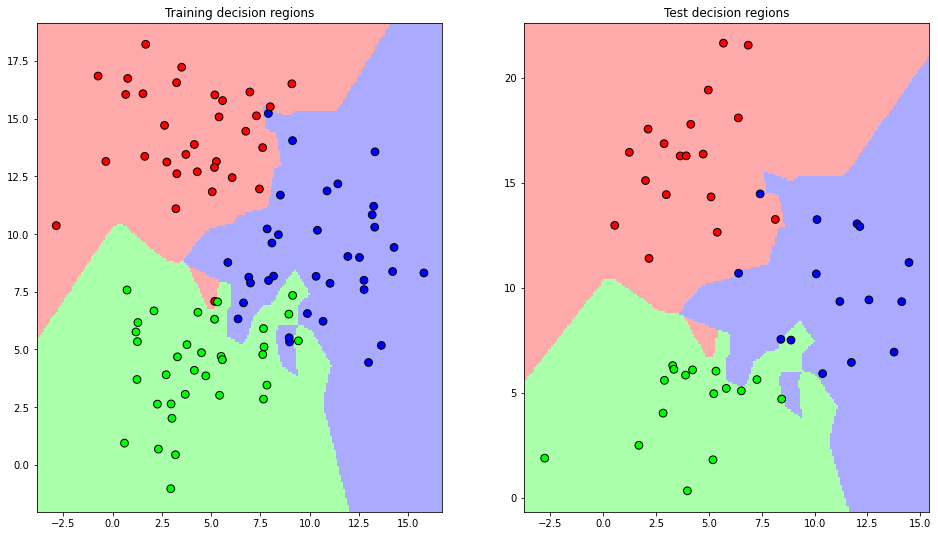

In [95]:
# %%timeit
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,2,1)
my.plot_decision_regions(train.inputs, train.target, nn, title="Training decision regions", ax=ax)
ax = fig.add_subplot(1,2,2)
my.plot_decision_regions(test.inputs, test.target, nn, title="Test decision regions", ax=ax)

## CHALLENGE
Write a function that takes a confusion matrix with more than two classes(such as the above `cm` matrix with 3 classes: `A`, `B`, and `C`) and a class index (such as 0, 1, or 2) and returns the sensitivity, specificity, precision, and $F_1$ metrics for the class of the given index given the confusion matrix. Test your function on the above confusion matrix `cm`.

**HINT**: Convert the confusion matrix into a $2 \times 2$ matrix representing the given class versus everything else.

In [107]:
def confusion_matrix_analysis(confusion_matrix, class_index):
  '''
  Function will return selected class as first row and col.
  Second row and col will be all other indices
  '''
  # validate that confusion_matrix has row count == col count
  if not all(len(cm)==len(r) for r in cm):
    raise Exception('Rows and columns of matrix are not equal.')

  # validate that class index is in range
  if class_index >= len(confusion_matrix):
    raise Exception(f'Class index {class_index} must be in range(0, {len(confusion_matrix)})')

  # create new 2x2 confusion_matrix with class_index against all else
  tp = confusion_matrix[class_index][class_index]
  fp = sum([confusion_matrix[class_index][c]
                  for c in range(len(confusion_matrix))
                  if c != class_index])
  fn = sum([confusion_matrix[r][class_index]
                  for r in range(len(confusion_matrix))
                  if r != class_index])
  tn = sum([confusion_matrix[r][c]
                  for r in range(len(confusion_matrix))
                  for c in range(len(confusion_matrix))
                  if c != class_index and r != class_index])
  new_matrix = [[tp, fp], [fn, tn]]

  # calculate sensitivity, specificity, precision, and F1 score
  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)
  precision = tp / (tp + fp)
  F1 = 2 * ((precision * sensitivity) / (precision + sensitivity))

  return sensitivity, specificity, precision, F1

In [108]:
print(f'Confusion matrix: \n{cm}\n')
for c in range(len(cm)):
    ss, sp, pr, f1 = confusion_matrix_analysis(cm, c)
    print(f'Class: {c}\n{"-"*50}\n\t{"Sensitivity:":<20}{ss}\n\t{"Specificity:":<20}{sp}\n\t{"Precision:":<20}{pr}\n\t{"F1:":<20}{f1}')

Confusion matrix: 
[[18  0  0]
 [ 0 16  0]
 [ 1  1 13]]

Class: 0
--------------------------------------------------
	Sensitivity:        0.9473684210526315
	Specificity:        1.0
	Precision:          1.0
	F1:                 0.972972972972973
Class: 1
--------------------------------------------------
	Sensitivity:        0.9411764705882353
	Specificity:        1.0
	Precision:          1.0
	F1:                 0.9696969696969697
Class: 2
--------------------------------------------------
	Sensitivity:        1.0
	Specificity:        0.9444444444444444
	Precision:          0.8666666666666667
	F1:                 0.9285714285714286
